# Задача классификации изображений


Стоит задача написать нейросеть для классификации изображений на  классов: Television, Sofas, Jeans, T-shirt и Other.

Для этого вначале подключим все необходимые библиотеки. Так же для удобства будем работать в текущей директории и скроем сообщения о предупреждениях:

In [88]:
## -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import os
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score 
import csv
import warnings 
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from skimage import io

os.chdir(os.getcwd())
warnings.filterwarnings('ignore')

Объявим класс для инициализации нашего датасета, основываясь на структуре используемых csv файлов

In [89]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = io.imread(img_path)
        label = self.img_labels.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

Для корректоной работы нейросети, изображения должны быть в одном формате, соответственно приведем все изображения к размеру 150x150 и переведем их в тензоры. 
С вышеуказанными изменениями получем два датасета. Первый - с 4мя классами Television, Sofas, Jeans, T-shirt и второй, включающий в себя изображения для класса other.

In [90]:
transform1 = transforms.Compose([         
            v2.ToTensor(),
            v2.Resize([150, 150])])

train_data = ImageDataset(annotations_file = 'table.csv', img_dir = 'test_data', transform=transform1)
train_dataD = ImageDataset(annotations_file = 'other3.csv', img_dir = 'test_data', transform=transform1)

Поделим оба датасета на обучающий, валидационный и тестовый:

In [91]:
train_size = int(len(train_data) * 0.70)
val_size = int(len(train_data) * 0.20)
test_size = len(train_data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(train_data, [train_size, val_size, test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
val_loder = torch.utils.data.DataLoader(val_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)

train_sizeD = int(len(train_dataD) * 0.70)
val_sizeD = int(len(train_dataD) * 0.20)
test_sizeD = len(train_dataD) - train_sizeD - val_sizeD
train_dataD, val_dataD, test_dataD = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_loaderD = torch.utils.data.DataLoader(train_dataD, batch_size=20, shuffle=True)
val_loderD = torch.utils.data.DataLoader(val_dataD, batch_size=20, shuffle=True)
test_loaderD = torch.utils.data.DataLoader(test_dataD, batch_size=20, shuffle=False)


Объявим нашу модель:

In [92]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        #150*150*3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(3,3)) 
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv3 = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=(3,3))
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12*17*17, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 4)

    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x

Объявим функцию для оценки:

In [93]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):
        
        X_batch, y_batch = batch
        num_elements += y_batch.size(0)
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1).cpu()
            
            num_correct += torch.sum(y_pred == y_batch)
    accuracy = num_correct / num_elements
            
    return accuracy, np.mean(losses)

Объявим функцию для обучения нашей сети. Вней реализован механизм отслеживания точности и потерь на валидационной выборке. При этом сохраняется модель с наименьшим значением потерь на валидации, что позваляет избежать переобучения:

In [94]:
def train(model, loss_fn, optimizer, n_epoch, load, val):
    global m1, m2, m3, m4
    num_iter = 0
    minloss = 0
    for epoch in range(n_epoch):

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(load):
            X_batch, y_batch = batch
            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward()
            optimizer.step() 
            optimizer.zero_grad() 
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)
            num_iter += 1

        val_accuracy, val_loss = evaluate(model, val, loss_fn=loss_fn)
            
        model.train(False)
        accuracy = (sum(running_accuracies) * 100 / len(running_accuracies)).numpy()
        losst = sum(running_losses) * 100 / len(running_losses)
        print("Epoch:", str(epoch+1))
        print("Train | accuracy:", accuracy, ", loss:", losst)
        print("Validation | accuracy:", val_accuracy.numpy() * 100, ", loss:", val_loss * 100)
        m1 += [accuracy]
        m2 += [losst]
        m3 += [val_accuracy.numpy() * 100]
        m4 += [val_loss * 100]
        print("__________________________________________________________")
        if val_loss <= minloss:
            torch.save(model.state_dict(), './model.pt')
            minloss = val_loss
        
    return model

Следующая функция служит для реализации дообучения нашей сети. Последний слой заменяется, а некоторое количество предыдущих слоев замораживаются, что позволяет сохранить веса, полученные при первичном обучении:

In [95]:
def create_model(model, num_freeze_layers, num_out_classes):
    model.fc3 = nn.Linear(512, num_out_classes)
    model.load_state_dict(torch.load('model.pt'))
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

Создадим модель, перенесем вычисления на gpu и будем теренровать её 10 эпох (такое значение избыточно, но в обучении есть защита от переобучения)

In [96]:
m1 = []
m2 = []
m3 = []
m4 = []
model = ConvNet()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = train(model, loss_fn, optimizer, 20, train_loader, val_loder)

Epoch: 1
Train | accuracy: 26.574074 , loss: 138.51476731123748
Validation | accuracy: 25.827813148498535 , loss: 132.76813328266144
__________________________________________________________
Epoch: 2
Train | accuracy: 55.092598 , loss: 101.73649633372271
Validation | accuracy: 66.22516512870789 , loss: 56.91821202635765
__________________________________________________________
Epoch: 3
Train | accuracy: 81.20371 , loss: 52.50469164715873
Validation | accuracy: 90.72847962379456 , loss: 25.94428425654769
__________________________________________________________


Посмотрим на график точности и потерь для тестовой и валидационной выборок. 

[array(38.98148, dtype=float32), array(84.25927, dtype=float32), array(90.92593, dtype=float32), array(92.40741, dtype=float32), array(95.185196, dtype=float32), array(95.925934, dtype=float32), array(97.77778, dtype=float32), array(98.24075, dtype=float32), array(98.333336, dtype=float32), array(99.07409, dtype=float32), array(98.333336, dtype=float32), array(99.444435, dtype=float32), array(99.44445, dtype=float32), array(98.333336, dtype=float32), array(99.62963, dtype=float32), array(97.40741, dtype=float32), array(99.07407, dtype=float32), array(99.81481, dtype=float32), array(99.44444, dtype=float32), array(99.81481, dtype=float32)] [132.57441211629796, 48.72042191801248, 27.561249611554324, 22.22539251325307, 13.454879668575746, 13.8287005049211, 7.079537268038149, 6.026331165426031, 5.509984569141158, 2.513693497705929, 4.35392043415319, 1.378332486233881, 1.465750216556006, 5.217852332215342, 2.271545072370726, 7.242888809371464, 3.6662232911179737, 0.8903462921773974, 0.95677

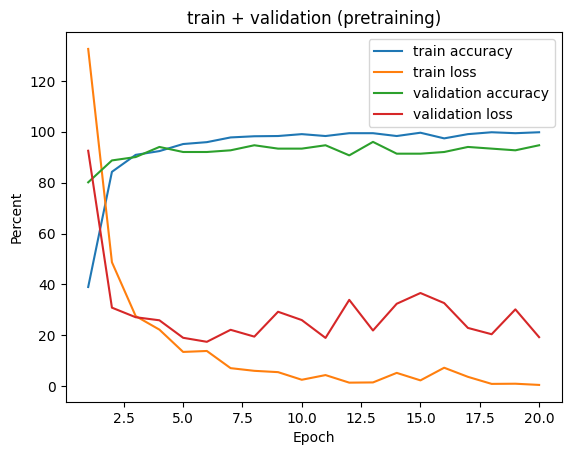

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
print(m1, m2, m3, m4)
plt.plot(x, m1, label='train accuracy')
plt.plot(x, m2, label='train loss')
plt.plot(x, m3, label='validation accuracy')
plt.plot(x, m4, label='validation loss')
plt.title('train + validation (pretraining)')  # заголовок графика
plt.xlabel('Epoch')  # подпись оси x
plt.ylabel('Percent')  # подпись оси y
plt.legend()  # добавляем легенду

# Отображаем график
plt.show()

Заметим, что после определенной эпохи значение потери на валидации начинает расти, что значит, что модель перееобучилась, поэтому необходимо ее вовремя сохранить.


Заморозим все слои кроме последнего, заменив его на слой с 5ью выходами. Дообучим модель на датасете с 5ью классами:

In [ ]:
m1 = []
m2 = []
m3 = []
m4 = []
model = create_model(model, 3, 5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = train(model, loss_fn, optimizer, 20, train_loaderD, val_loderD)
model.load_state_dict(torch.load('model.pt'))

Epoch: 1
Train | accuracy: 94.23613 , loss: 19.945313918869942
Validation | accuracy: 94.29824352264404 , loss: 17.699673476939402
__________________________________________________________
Epoch: 2
Train | accuracy: 94.98613 , loss: 15.915554042439908
Validation | accuracy: 95.61403393745422 , loss: 12.341382789115112
__________________________________________________________
Epoch: 3
Train | accuracy: 95.23613 , loss: 12.11868098587729
Validation | accuracy: 95.17543911933899 , loss: 14.513704009974996
__________________________________________________________
Epoch: 4
Train | accuracy: 97.73612 , loss: 7.770784163149074
Validation | accuracy: 95.61403393745422 , loss: 12.000715356164921
__________________________________________________________
Epoch: 5
Train | accuracy: 97.00001 , loss: 7.699819527915679
Validation | accuracy: 94.29824352264404 , loss: 17.930506620905362
__________________________________________________________
Epoch: 6
Train | accuracy: 99.000015 , loss: 3.765866

<All keys matched successfully>

[array(94.23613, dtype=float32), array(94.98613, dtype=float32), array(95.23613, dtype=float32), array(97.73612, dtype=float32), array(97.00001, dtype=float32), array(99.000015, dtype=float32), array(97.11112, dtype=float32), array(98.000015, dtype=float32), array(98.87501, dtype=float32), array(99.25, dtype=float32), array(99.00001, dtype=float32), array(99.00001, dtype=float32), array(99.11112, dtype=float32), array(98.625015, dtype=float32), array(99.50001, dtype=float32), array(98.750015, dtype=float32), array(99.62501, dtype=float32), array(99.5, dtype=float32), array(99.875, dtype=float32), array(98.98611, dtype=float32)] [19.945313918869942, 15.915554042439908, 12.11868098587729, 7.770784163149074, 7.699819527915679, 3.76586681290064, 7.765554269717541, 6.068467247532681, 3.627273441525176, 3.086357083375333, 3.379786062942003, 3.502000832595513, 3.3663049708411563, 4.591977516683983, 2.330427385313669, 2.6941746487136697, 1.3881060727362637, 1.1896083322062623, 0.67334728094010

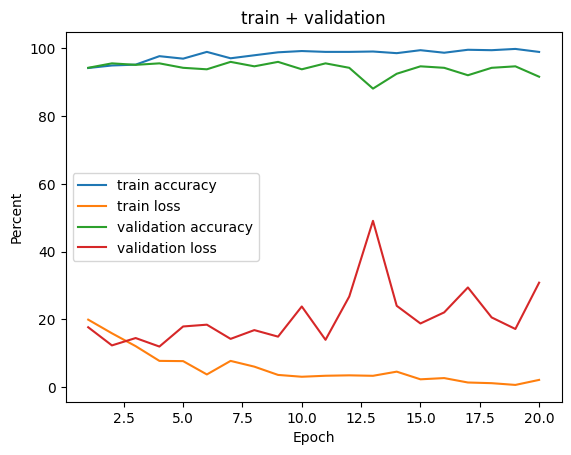

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
print(m1, m2, m3, m4)
plt.plot(x, m1, label='train accuracy')
plt.plot(x, m2, label='train loss')
plt.plot(x, m3, label='validation accuracy')
plt.plot(x, m4, label='validation loss')
plt.title('train + validation')
plt.xlabel('Epoch')
plt.ylabel('Percent') 
plt.legend()
plt.show()

Посморим итоговые результаты на обучающем и тестовом датасетах:

In [ ]:
train_accuracy, _ = evaluate(model, train_loaderD, loss_fn)
print('Train accuracy:', train_accuracy.numpy())

test_accuracy, _ = evaluate(model, test_loaderD, loss_fn)
print('Test accuracy:', test_accuracy.numpy())

Train accuracy: 0.9586466
Test accuracy: 0.98245615
